# Seq2seq model: Spanish-English Translation

This notebook is from Lazy Programmer's NLP3 course (Advanced NLP). In this notebook, a Seq2seq model consisting of an encoder and a decoder (both LSTMs) were trained on the spa-eng.text dataset to do English-Spanish translation

In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [3]:
#input to the encoder
input_texts = [] # sentence in original language

#input to the decoder
target_texts_inputs = [] # sentence in target language offset by 1 (<sos> + translation)

#target text for training
target_texts = [] # sentence in target language (translation + <eos>)


In [4]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('spa-eng/spa.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))


num samples: 10000


In [5]:
input_texts[10], target_texts[10], target_texts_inputs[10]

('Run.', 'Corra. <eos>', '<sos> Corra.')

# Tokenizing & padding input/output sequences 

In [6]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print(max_len_input)

Found 2274 unique input tokens.
5


In [7]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print(max_len_target)

Found 6378 unique output tokens.
10


In [8]:
# pad the 3 sequences: encoder input, decoder input, decoder target
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')


encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 15]
decoder_inputs[0]: [   2 1450    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 10)


# Store pretrained Glove in word2vec

In [9]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


# Create the Embedding layer

In [10]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

Filling pre-trained embeddings...


# Build seq2seq model

The Seq2Seq model has 2 parts: an encoder part and a decoder part. 

- The encoder part comprises an embedding layer (with pretrained word vectors like Glove), and an LSTM/GRU layer. The input to the enccoder is the input sequence. Only the hidden state h (and the cell state c) of the encoder will be passed into the decoder GRU (LSTM). 

- The decoder part also comprises an embedding layer and a LSTM/GRU layer. The embedding layer of the decoder does not need to have pretrained word vectors (although it's fine to use it). The inputs to the decoder are the hidden (and cell) states of the encoder, and the target input sequence (which is the target sequence but with the token 'sos' at the beginning instead of the token 'eos' at the end).

In [11]:
#GRU VERSION

########## ENCODER ##########
#INPUT - EMBEDDING
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

#ENCODER-GRU
encoder = GRU(
  LATENT_DIM,
  return_state=True,
)
encoder_outputs, h = encoder(x)
# keep only the states to pass into decoder
encoder_states = [h] # gru


########### DECODER ##########
#INPUT-EMBEDDING
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
#DECODER-GRU
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_gru = GRU(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
)
decoder_outputs, _ = decoder_gru(
   decoder_inputs_x,
   initial_state=encoder_states
 )
########### FINAL DENSE ##########
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model_gru = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 100)       227500      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 100)      637900      ['input_2[0][0]']                
                                                                                              

In [12]:
#LSTM VERSION
########## ENCODER ##########
#INPUT - EMBEDDING
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
#ENCODER-LSTM
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
)
encoder_outputs, h, c = encoder(x)
# keep only the states to pass into decoder
encoder_states = [h, c]


########### DECODER ##########
#INPUT-EMBEDDING
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))
# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
#DECODER-LSTM
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)
########### FINAL DENSE ##########
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 100)       227500      ['input_3[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 10, 100)      637900      ['input_4[0][0]']                
                                                                                            

# Train the seq2seq model (LSTM version)

In [13]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [14]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

#model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])


In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 34s 251ms/step - loss: 2.2289 - accuracy: 0.1003 - val_loss: 2.5976 - val_accuracy: 0.1079
Epoch 2/100
125/125 [==============================] - 31s 252ms/step - loss: 2.1032 - accuracy: 0.1105 - val_loss: 2.6078 - val_accuracy: 0.1173
Epoch 3/100
125/125 [==============================] - 33s 266ms/step - loss: 2.0062 - accuracy: 0.1157 - val_loss: 2.5906 - val_accuracy: 0.1224
Epoch 4/100
125/125 [==============================] - 34s 269ms/step - loss: 1.9093 - accuracy: 0.1219 - val_loss: 2.5191 - val_accuracy: 0.1313
Epoch 5/100
125/125 [==============================] - 33s 267ms/step - loss: 1.8138 - accuracy: 0.1275 - val_loss: 2.4809 - val_accuracy: 0.1351
Epoch 6/100
125/125 [==============================] - 33s 261ms/step - loss: 1.7281 - accuracy: 0.1339 - val_loss: 2.4357 - val_accuracy: 0.1386
Epoch 7/100
125/125 [==============================] - 35s 278ms/step - loss: 1.6502 - accuracy: 0.1394 - val_loss: 2.3898 -

Epoch 57/100
125/125 [==============================] - 33s 264ms/step - loss: 0.4192 - accuracy: 0.2673 - val_loss: 2.8731 - val_accuracy: 0.1822
Epoch 58/100
125/125 [==============================] - 33s 260ms/step - loss: 0.4121 - accuracy: 0.2682 - val_loss: 2.9022 - val_accuracy: 0.1781
Epoch 59/100
125/125 [==============================] - 33s 268ms/step - loss: 0.4058 - accuracy: 0.2687 - val_loss: 2.9397 - val_accuracy: 0.1663
Epoch 60/100
125/125 [==============================] - 33s 261ms/step - loss: 0.3989 - accuracy: 0.2706 - val_loss: 2.9569 - val_accuracy: 0.1775
Epoch 61/100
125/125 [==============================] - 33s 261ms/step - loss: 0.3922 - accuracy: 0.2711 - val_loss: 2.9490 - val_accuracy: 0.1722
Epoch 62/100
125/125 [==============================] - 33s 266ms/step - loss: 0.3854 - accuracy: 0.2724 - val_loss: 2.9522 - val_accuracy: 0.1776
Epoch 63/100
125/125 [==============================] - 33s 265ms/step - loss: 0.3796 - accuracy: 0.2734 - val_loss: 3

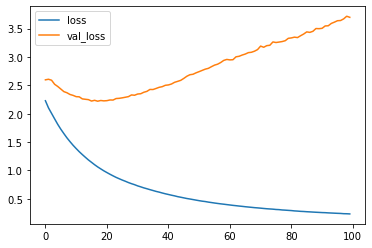

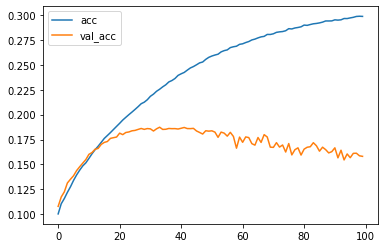

In [17]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')

# Create a sampling model

In [18]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)


In [19]:
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

In [20]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [21]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq, verbose = 0)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value, verbose = 0
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [22]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I can run.
Translation: puedo correr.
Continue? [Y/n]y
-
Input: Tom's crazy.
Translation: tom es loco.
Continue? [Y/n]y
-
Input: There it is!
Translation: ¡allá está!
Continue? [Y/n]y
-
Input: Tom remembered.
Translation: tom se estrelló.
Continue? [Y/n]y
-
Input: I'm ugly.
Translation: soy fea.
Continue? [Y/n]y
-
Input: Mary giggled.
Translation: mary soltó una risita.
Continue? [Y/n]y
-
Input: I feel at ease.
Translation: me siento en casa.
Continue? [Y/n]y
-
Input: That'll last.
Translation: eso durará.
Continue? [Y/n]y
-
Input: I won!
Translation: ¡he ganado!
Continue? [Y/n]y
-
Input: Can it be fixed?
Translation: ¿puede entrar?
Continue? [Y/n]y
-
Input: Oh, I got it.
Translation: oh, lo obtuve.
Continue? [Y/n]y
-
Input: Tom drove fast.
Translation: tom despacio!
Continue? [Y/n]n
